# SberMarket Competition

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack, vstack, find, coo_matrix
import os
import pickle
from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostClassifier, cv, Pool
from catboost.utils import eval_metric
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
print(pd.__version__)
print(np.__version__)
print(catboost.__version__)

1.3.5
1.21.4
1.0.3


In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


### Data Cleaning

<AxesSubplot:xlabel='user_id'>

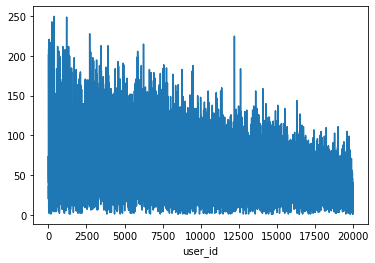

In [6]:
cart_count = train[['user_id', 'cart']].drop_duplicates().groupby('user_id').cart.count()
cart_count.plot()

In [7]:
cartq = cart_count.quantile(0.95)
cartq

118.0

<AxesSubplot:xlabel='user_id'>

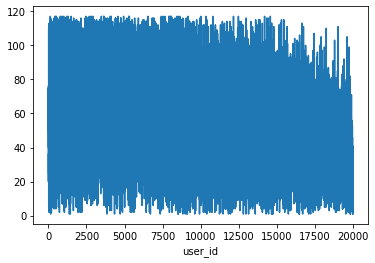

In [8]:
train_users = cart_count[cart_count < cartq]
train_users.plot()

In [9]:
train_users.index.size

18988

In [10]:
train_clean = train[train.user_id.isin(train_users.index)]

<AxesSubplot:xlabel='user_id'>

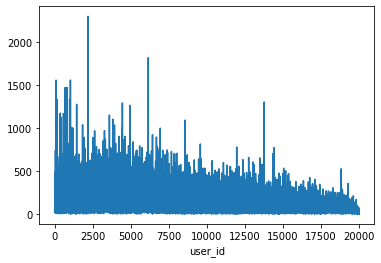

In [11]:
cart_count = train_clean.groupby('user_id')['cart'].count()
cart_count.plot()

In [12]:
cartq = cart_count.quantile(0.9)
cartq

279.0

<AxesSubplot:xlabel='user_id'>

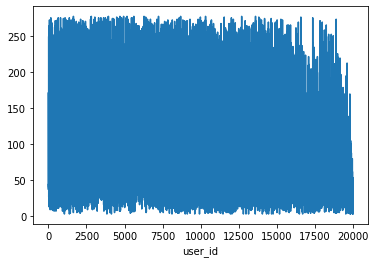

In [13]:
train_users = cart_count[cart_count < cartq]
train_users.plot()

In [14]:
train_clean = train_clean[train_clean.user_id.isin(train_users.index)]

In [15]:
train_clean.user_id.unique().size, train_clean.cart.unique().size

(17080, 830)

In [16]:
train_clean.to_csv('train_clean.csv', index=False)

In [4]:
def set_feature_names(columns):
    try:
        global names
        names += columns.to_list()
    except NameError:
        pass

### Target

In [5]:
def get_target(train):
    
    train['order_completed_at'] = pd.to_datetime(train.order_completed_at)
    
    train = train.assign(
        order_rank = lambda d: d.groupby('user_id').order_completed_at\
        .transform(lambda x: x.rank(method='dense')),
        max_order_rank = lambda d: d.groupby('user_id').order_rank.transform(lambda x: x.max())
    )
      
    test = train.query('order_rank == max_order_rank')\
    .drop(['order_rank', 'max_order_rank'], axis=1)
    
    train = train.query('order_rank < max_order_rank')\
    .drop(['order_rank', 'max_order_rank'], axis=1)
                 
    target = train[['user_id', 'cart']].drop_duplicates()\
    .merge(test.drop('order_completed_at', axis=1).assign(target=1),
           on=['user_id', 'cart'], how='left')\
    .fillna(0)\
    .sort_values(['user_id', 'cart'])[['target', 'user_id', 'cart']]
    
    set_feature_names(target.columns)
    
    return csr_matrix(target.values.astype('int')), train

### Orders and Reorders

In [6]:
def get_reorders(train):

    train = train.assign(order_rank = train.groupby('user_id').order_completed_at\
                         .transform(lambda x: x.rank(method='dense')))\
    .assign(max_order_rank = lambda d: d.groupby('user_id').order_rank\
            .transform(lambda x: x.max()))

    reorders = pd.pivot_table(train.merge(train.assign(order_rank = train.order_rank - 1), 
                                          on=['user_id', 'order_rank', 'cart'])\
                              .assign(reorders = lambda x: x.user_id ** 0), 
                              values='reorders', index=['user_id', 'cart'], aggfunc='count')\
    .assign(reorder_rank = lambda d: d.groupby('user_id').reorders\
            .transform(lambda x: x.rank(method='dense')))

    orders = pd.pivot_table(train, values='order_completed_at', index=['user_id', 'cart'], 
                            aggfunc='count')\
    .assign(order_rank = lambda d: d.groupby('user_id').order_completed_at\
            .transform(lambda x: x.rank(method='dense')))\
    .rename(columns={'order_completed_at': 'orders'})
    
    reorders = reorders.merge(orders, on=['user_id', 'cart'], how='outer').fillna(0)\
    .sort_values(['user_id', 'reorders', 'orders'], ascending=[True, False, False]).reset_index()
    
    thr = pd.pivot_table(train, values='cart', index=['user_id', 'order_completed_at'], 
                         aggfunc='count')\
    .groupby('user_id').agg([lambda x: x.value_counts().index[0], 'min', 'max', 'mean'])\
    .rename(columns={'<lambda_0>': 'mode'}).astype(int)\
    .transpose().reset_index(level=0).drop('level_0', axis=1).transpose()\
    .sort_values('user_id')
    
    def get_indexes(data, thr):    
        users = data.user_id.unique()
        cart = pd.pivot_table(data, values='cart', index='user_id', aggfunc='count').cart
        indexes, start = [0], 0

        for user in users:
            gap = cart[user] - thr[user]

            if gap > 0:
                indexes += list(range(start, start + thr[user]))
                start = indexes[-1] + gap + 1
            else:
                indexes += list(range(start, start + cart[user]))
                start = indexes[-1] + 1

        return indexes[1:]
    
    offers = []

    for offer in thr.columns:
        indexes = get_indexes(reorders, thr[offer])

        offers.append(
            reorders.iloc[indexes, :].assign(target=1)\
            .merge(reorders[['user_id', 'cart']], on=['user_id', 'cart'], how='right')\
            .fillna(0)\
            .sort_values(['user_id', 'reorders', 'orders'], ascending=[True, False, False])\
            [['target']].values
        )
        
    offers = pd.DataFrame(np.hstack(offers), columns=['mode_offer', 'min_offer', 'max_offer', 'mean_offer'])    
    
    reorders = pd.concat([reorders, offers], axis=1)\
    .sort_values(['user_id', 'cart']).set_index(['user_id', 'cart'])

    set_feature_names(reorders.columns)
    
    return csr_matrix(reorders.values.astype(int))

### Binary Orders

In [7]:
def get_orders(train):

    train = train.assign(
        cart_rank = train.groupby(['user_id', 'order_completed_at']).cart.\
        transform(lambda x: x.rank(method='dense')),
        cart_id = lambda x: x.user_id.astype(str) + ';' + x.cart.astype(str))\
    .convert_dtypes()

    orders = train.pivot(index=['user_id', 'order_completed_at'], columns='cart_rank', values='cart_id')

    unique_order_count = train[['user_id', 'order_completed_at']].drop_duplicates()\
    .groupby('user_id').count().order_completed_at
    
    sp_data, sp_index = [], []
    unique_users = orders.index.get_level_values('user_id').unique()
    
    for user_id in unique_users:
        frame = orders.query('user_id == @user_id')
        row_indices, col_indices, data, order_id = [], [], [], 0
        vocabulary = {}
        
        for order in frame.values:  
            for cart in order:
                if pd.notna(cart):
                    index = vocabulary.setdefault(cart, len(vocabulary))
                    row_indices.append(order_id)
                    col_indices.append(index)
                    data.append(1)
                    user_id = int(cart.split(';')[0])

            unique_order_count[user_id] -= 1
            order_id += 1

            if not unique_order_count[user_id]:
                order_id = 0
                
        sp_data.append(coo_matrix((data, (row_indices, col_indices)), dtype=int).transpose())
        sp_index += pd.Series(vocabulary).index.tolist()
        
    max_size = max([matrix.shape[1] for matrix in sp_data])
    rep = [np.ceil(max_size/matrix.shape[1]).astype(int)-1 for matrix in sp_data]
    sp_data = [csr_matrix(hstack([matrix]*rep[n] + [matrix]))[:,:max_size]  for n, matrix in enumerate(sp_data)]
    sp_data = vstack(sp_data)

    orders = pd.DataFrame(sp_data.toarray(), index=sp_index, 
                          columns=list(map(lambda x: 'order_'+str(x), list(range(max_size)))))\
    .reset_index()\
    .assign(user_id = lambda x: x['index'].apply(lambda y: int(y.split(';')[0])),
            cart = lambda x: x['index'].apply(lambda y: int(y.split(';')[1])))\
    .drop('index', axis=1)\
    .sort_values(['user_id', 'cart']).set_index(['user_id', 'cart'])
    
    set_feature_names(orders.columns)
    
    return csr_matrix(orders.values.astype(int))

### Time Periods since Last Orders

In [8]:
def get_delays(train):
    
    train['order_completed_at'] = pd.to_datetime(train.order_completed_at)
    
    time_diff = train.assign(
        cart_rank = lambda d: d.groupby(['user_id', 'cart']).order_completed_at\
        .transform(lambda x: x.rank(method='dense')), 
        max_cart_rank = lambda d: d.groupby(['user_id', 'cart']).cart_rank\
        .transform(lambda x: x.max()))\
    .query('cart_rank == max_cart_rank')\
    .assign(delay = lambda x: train.order_completed_at.max() - x.order_completed_at)\
    .assign(delay = lambda x: x.delay.dt.components.days)\
    .drop(['order_completed_at', 'cart_rank', 'max_cart_rank'], axis=1)\
    .sort_values(['user_id', 'cart']).set_index(['user_id', 'cart'])
    
    set_feature_names(time_diff.columns)
    
    return csr_matrix(time_diff.values.astype('int'))

### Days of the Week 

In [9]:
def get_weekdays(train):

    weekdays = train.assign(
        day = train.groupby('user_id').order_completed_at.transform(lambda x: x.dt.dayofweek)
    )\
    .pivot_table(index=['user_id', 'cart'], columns='day', values='order_completed_at', aggfunc='count')\
    .merge(train[['user_id', 'cart']].drop_duplicates(), on=['user_id', 'cart'], how='outer')\
    .fillna(0).set_index(['user_id', 'cart'])\
    .rename(columns={0:'Mo', 1:'Tu', 2:'We', 3:'Th', 4:'Fr', 5:'Sa', 6:'Su'})

    weekdays = weekdays.reset_index()\
    .merge(weekdays.groupby('cart').sum(), on='cart')\
    .sort_values(['user_id', 'cart']).set_index(['user_id', 'cart'])
    
    set_feature_names(weekdays.columns)
    
    return csr_matrix(weekdays.values.astype(int))

### Hours

In [10]:
def get_hours(train):
    
    train['order_completed_at'] = pd.to_datetime(train.order_completed_at)

    hours = train.assign(
        hour = train.groupby('user_id').order_completed_at.transform(lambda x: x.dt.hour)
    )\
    .assign(hour = lambda d: d.hour.apply(lambda x: 'hr'+str(x)))\
    .pivot_table(index=['user_id', 'cart'], columns='hour', values='order_completed_at', aggfunc='count')\
    .merge(train[['user_id', 'cart']].drop_duplicates(), on=['user_id', 'cart'], how='outer')\
    .fillna(0).set_index(['user_id', 'cart'])

    hours = hours.reset_index()\
    .merge(hours.groupby('cart').sum(), on='cart')\
    .sort_values(['user_id', 'cart']).set_index(['user_id', 'cart'])
    
    set_feature_names(hours.columns)
    
    return csr_matrix(hours.values.astype(int))

### Statistics

In [11]:
def get_stats(train):
    
    train = train.assign(
        day = train.groupby('user_id').order_completed_at.transform(lambda x: x.dt.date),
        month = train.groupby('user_id').order_completed_at.transform(lambda x: x.dt.month),
        year = train.groupby('user_id').order_completed_at.transform(lambda x: x.dt.year))\
    .assign(month = lambda x: x.year.astype(str) + '-' + x.month.astype(str))\

    stats = pd.DataFrame()

    pt = pd.pivot_table(train, values='order_completed_at', index=['user_id', 'cart'], columns='month', 
                        aggfunc='count')
    stats['M_min'] = pt.min(1)
    stats['M_max'] = pt.max(1)
    stats['M_med'] = pt.median(1)

    pt = pd.pivot_table(train, values='order_completed_at', index=['user_id', 'cart'], columns='year', 
                        aggfunc='count')
    stats['Y_min'] = pt.min(1)
    stats['Y_max'] = pt.max(1)
    stats['Y_med'] = pt.median(1)

    stats = stats.sort_values(['user_id', 'cart'])    
    set_feature_names(stats.columns)
    
    return csr_matrix(stats.values.astype('int'))

### Merging Data

In [12]:
data_dir = './sparse_data'

In [13]:
def get_features(source): 
    global names
    names = []
    target, train = get_target(source)
    sparse_data = []
    sparse_data.append(target)
    sparse_data.append(get_reorders(train))
    sparse_data.append(get_orders(train))
    sparse_data.append(get_delays(train))
    sparse_data.append(get_weekdays(train))
    sparse_data.append(get_hours(train))
    sparse_data.append(get_stats(train))
    return sparse_data

In [14]:
raw_data = get_features(pd.read_csv('train_clean.csv'))

In [15]:
[m.shape for m in raw_data]

[(712474, 3),
 (712474, 8),
 (712474, 85),
 (712474, 1),
 (712474, 14),
 (712474, 48),
 (712474, 6)]

In [16]:
raw_data = csr_matrix(hstack(raw_data))

In [17]:
raw_data.shape

(712474, 165)

In [18]:
with open(os.path.join(data_dir, 'raw_train.pkl'), 'wb') as fp:
    pickle.dump((raw_data, names), fp)

In [19]:
sample_submission = pd.read_csv('sample_submission.csv')\
.assign(user_id = lambda x: x.id.apply(lambda y: int(y.split(';')[0])),
        cart = lambda x: x.id.apply(lambda y: int(y.split(';')[1])))\
.drop(['id'], axis=1)[['user_id', 'cart']]

In [20]:
raw_data = get_features(pd.read_csv('train.csv').merge(sample_submission, on=['user_id', 'cart']))
raw_data = csr_matrix(hstack(raw_data))

In [21]:
raw_data.shape

(739483, 266)

In [22]:
with open(os.path.join(data_dir, 'raw_test.pkl'), 'wb') as fp:
    pickle.dump((raw_data, names), fp)

In [4]:
from sklearn.feature_selection import mutual_info_classif

In [5]:
with open(os.path.join(data_dir, 'raw_train.pkl'), 'rb') as sd:
    raw_train, names = pickle.load(sd)

In [11]:
X = raw_train[:,3:].toarray() 
y = raw_train[:,0].toarray().ravel()
mutual_info = mutual_info_classif(X, y, random_state=0)

In [12]:
with open(os.path.join(data_dir, 'raw_train_mi.pkl'), 'wb') as fp:
    pickle.dump(mutual_info, fp)

### EDA

In [3]:
data_dir = './sparse_data'
with \
open(os.path.join(data_dir, 'raw_train.pkl'), 'rb') as sd, \
open(os.path.join(data_dir, 'raw_train_mi.pkl'), 'rb') as mi:
    raw_train, names = pickle.load(sd)
    mutual_info = pickle.load(mi)

In [4]:
valuable_features = np.hstack([[0,1,2], np.where(mutual_info > 0)[0] + 3])
train = pd.DataFrame(raw_train[:,valuable_features].toarray(), columns=np.array(names)[valuable_features])
train.shape

(712474, 164)

In [5]:
y2y_feature_names = train.filter(like='_y').columns
y2y_features = np.where(np.isin(train.columns, y2y_feature_names))[0]

binary_feature_names = train.columns[train.apply(pd.unique, 0).apply(len) == 2][1:]
binary_features = np.where(np.isin(train.columns, binary_feature_names))[0]

other_features = np.where(~np.isin(train.columns, np.hstack([binary_feature_names, y2y_feature_names])))[0][2:]
other_feature_names = train.columns[other_features]

In [7]:
def clean_data(d):
    q1, q3 = d.quantile(0.25), d.quantile(0.75)
    iqr = d.apply(stats.iqr)  
    outliers = ((d < (q1-1.5*iqr)) | (d > (q3+1.5*iqr))).any(1) 
    return outliers

In [8]:
def histplot(X, y, bins=10, ncols=7, figsize=(14,8)):
    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.6, wspace=0.6)
    nrows = X.shape[1]//ncols + 1
    
    for idx, feature in enumerate(X.columns):       
        plt.subplot(nrows, ncols, idx+1)
        ax = sns.histplot(data=X.assign(labels=y), x=feature, hue='labels', bins=bins, multiple='stack')
        plt.ylabel('')
        ax.get_legend().remove()

def boxplot(X, y, ncols=7, figsize=(14,8)):
    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.8, wspace=0.8)
    nrows = X.shape[1]//ncols + 1
    
    for idx, feature in enumerate(X.columns):       
        plt.subplot(nrows, ncols, idx+1)
        sns.boxplot(x=y, y=X[feature])

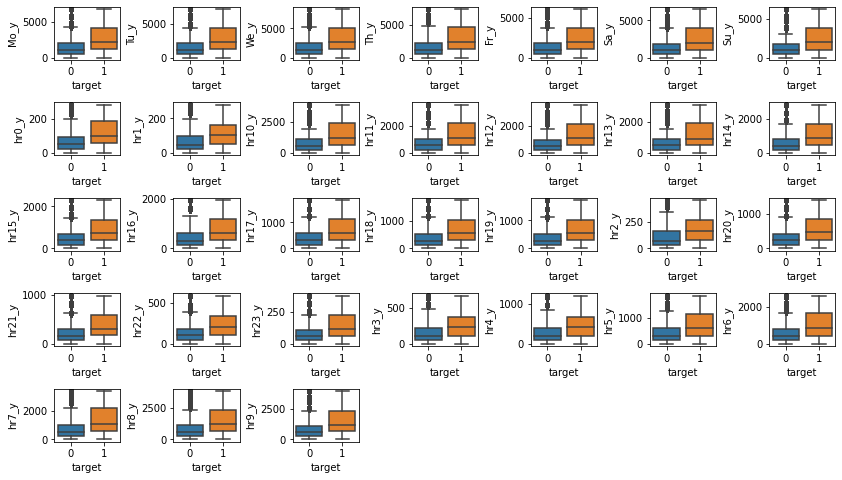

In [9]:
frame = train.iloc[:,y2y_features]
boxplot(frame, train.target)

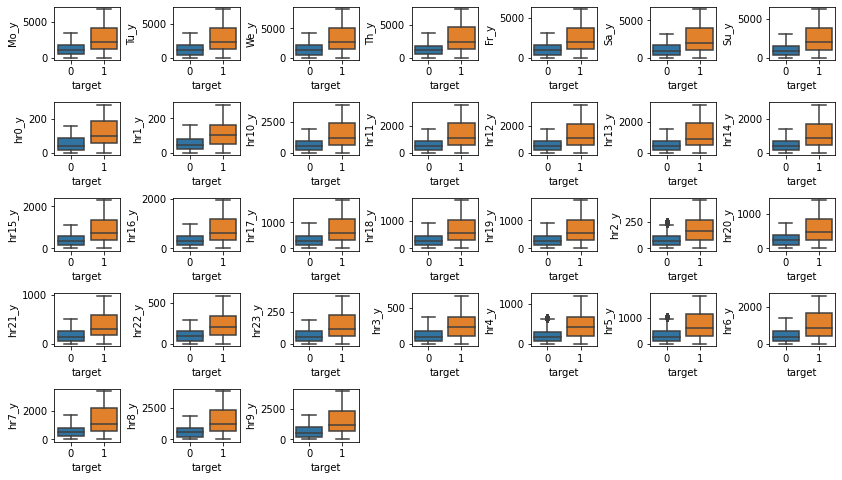

In [10]:
sub_frame = frame[train.target == 0]
outliers = sub_frame[clean_data(sub_frame)].index
frame_clean = frame.drop(outliers, axis=0)
clean_target = train['target'].drop(outliers, axis=0)
boxplot(frame_clean, clean_target)

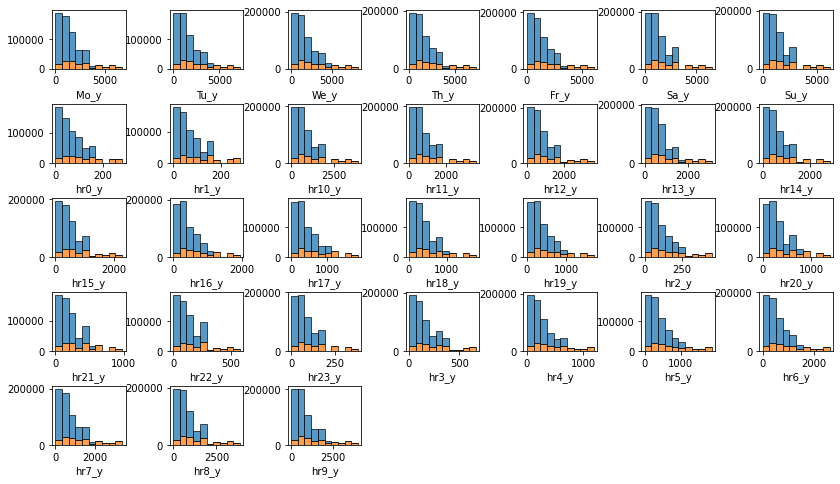

In [11]:
histplot(frame_clean, clean_target)

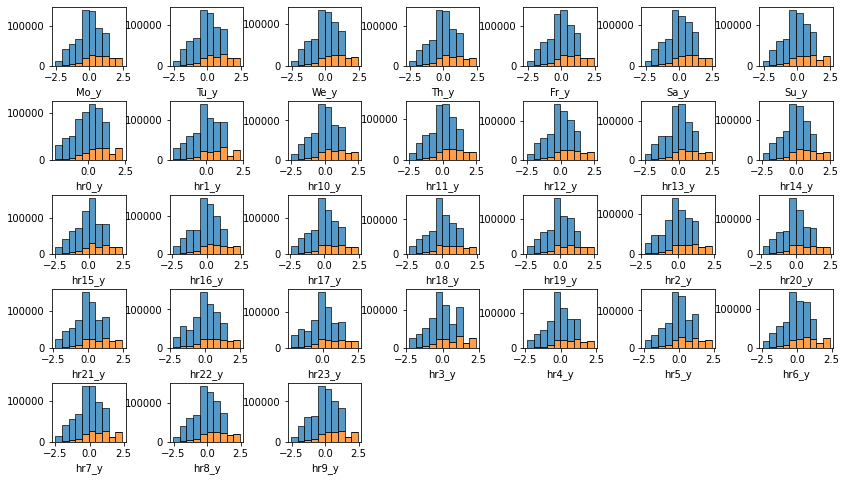

In [12]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
frame_pt = pt.fit_transform(frame_clean)
frame_pt = pd.DataFrame(frame_pt, columns=frame_clean.columns, index=frame_clean.index)

histplot(frame_pt, clean_target)

In [13]:
train_pt = pd.concat([train.drop(outliers, axis=0).drop(y2y_feature_names, axis=1), frame_pt], axis=1)

In [14]:
train_pt.shape

(667698, 164)

In [15]:
with open(os.path.join(data_dir, 'raw_test.pkl'), 'rb') as sd:
    raw_test, names = pickle.load(sd)    

In [16]:
test_cols = np.where(np.isin(names, train_pt.columns))[0]
test = pd.DataFrame(raw_test[:,test_cols].toarray(), columns=np.array(names)[test_cols])
frame = test.iloc[:,y2y_features]
frame_pt = pd.DataFrame(pt.fit_transform(frame), columns=frame.columns, index=frame.index)
test_pt = pd.concat([test.drop(y2y_feature_names, axis=1), frame_pt], axis=1)

In [17]:
test_pt.shape

(739483, 164)

In [18]:
cat_features = np.where(np.isin(train_pt.columns, other_feature_names))[0]

In [20]:
with open(os.path.join(data_dir, 'train.pkl'), 'wb') as fp:
    pickle.dump((csr_matrix(train_pt.values), train_pt.columns, cat_features), fp)
    
with open(os.path.join(data_dir, 'test.pkl'), 'wb') as fp:
    pickle.dump((csr_matrix(test_pt.values), test_pt.columns), fp)

### CV

In [4]:
def perform_cv(pool, nfold=3, seed=0):
    params = {}
    params['loss_function'] = 'Logloss'
    params['iterations'] = 500
    params['learning_rate'] = 0.5
    params['custom_metric'] = ['F1']

    cv_data = cv(
        params=params,
        pool=pool,
        fold_count=nfold,
        shuffle=True,
        partition_random_seed=seed,        
        stratified=True,
        plot=False,
        logging_level='Silent'
    )
    return cv_data

def print_cv_summary(cv_data):    
    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()
        
    print('Best validation Logloss score: {:.4f}±{:.4f} on step {}'.format(
        best_value, 
        cv_data['test-Logloss-std'][best_iter], 
        best_iter))

    print('F1: {:.4f}±{:.4f}'.format(
        cv_data['test-F1-mean'][best_iter],
        cv_data['test-F1-std'][best_iter]))

In [5]:
data_dir = './sparse_data'

with open(os.path.join(data_dir, 'train.pkl'), 'rb') as sd:
    train, _, cat_features = pickle.load(sd)

train = pd.DataFrame(train.toarray())
X = train.iloc[:,2:].convert_dtypes().to_numpy()
y = train.iloc[:,0].to_numpy()
cat_features = (cat_features - 2).tolist()

pool = Pool(X, label=y, cat_features=cat_features)
print_cv_summary(perform_cv(pool))

Best validation Logloss score: 0.3797±0.0004 on step 81
F1: 0.4931±0.0022


### CatBoost Model

In [4]:
data_dir = './sparse_data'

with \
open(os.path.join(data_dir, 'train.pkl'), 'rb') as train, \
open(os.path.join(data_dir, 'test.pkl'), 'rb') as test:
    train, names, cat_features = pickle.load(train)
    test, _ = pickle.load(test)

train = pd.DataFrame(train.toarray(), columns=names).convert_dtypes()
test = pd.DataFrame(test.toarray(), columns=names).convert_dtypes()

X, y = train.iloc[:,2:].to_numpy(), train.iloc[:,0].to_numpy()
X_test, y_test = test.iloc[:,2:].to_numpy(), test.iloc[:,0].to_numpy()
cat_features = (cat_features - 2).tolist()

X_train, \
X_val, \
y_train, \
y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

train_pool = Pool(
    X_train, 
    label=y_train,
    cat_features=cat_features
)
val_pool = Pool(
    X_val, 
    label=y_val,
    cat_features=cat_features
)
test_pool = Pool(
    X_test, 
    label=y_test,
    cat_features=cat_features
)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

params = {
    'iterations': 20000, 
    'early_stopping_rounds': 500,
    'random_seed': 0,   
    'task_type': 'GPU',
    'devices': '0:1',
    'class_weights': class_weights
}

model = CatBoostClassifier(**params)
model.fit(train_pool, verbose=1000, eval_set=val_pool)

Learning rate set to 0.012079
0:	learn: 0.6838564	test: 0.6839513	best: 0.6839513 (0)	total: 231ms	remaining: 1h 17m 7s
1000:	learn: 0.5093444	test: 0.5125644	best: 0.5125644 (1000)	total: 3m 53s	remaining: 1h 13m 58s
2000:	learn: 0.5060636	test: 0.5110878	best: 0.5110878 (2000)	total: 7m 37s	remaining: 1h 8m 34s
3000:	learn: 0.5036755	test: 0.5104556	best: 0.5104552 (2999)	total: 11m 15s	remaining: 1h 3m 46s
4000:	learn: 0.5016095	test: 0.5100474	best: 0.5100465 (3997)	total: 14m 51s	remaining: 59m 22s
5000:	learn: 0.4997260	test: 0.5097620	best: 0.5097619 (4999)	total: 18m 25s	remaining: 55m 15s
6000:	learn: 0.4979427	test: 0.5095469	best: 0.5095452 (5993)	total: 21m 58s	remaining: 51m 15s
7000:	learn: 0.4961483	test: 0.5093740	best: 0.5093740 (7000)	total: 25m 33s	remaining: 47m 27s
8000:	learn: 0.4944626	test: 0.5092428	best: 0.5092428 (8000)	total: 29m 6s	remaining: 43m 39s
9000:	learn: 0.4928077	test: 0.5091305	best: 0.5091302 (8998)	total: 32m 42s	remaining: 39m 57s
10000:	learn

In [5]:
y_pred = model.predict(test_pool)
f1_score(test_pool.get_label(), y_pred)

0.49999416187940776

In [9]:
sample_submission = pd.read_csv('sample_submission.csv')\
.assign(user_id = lambda x: x.id.apply(lambda y: int(y.split(';')[0])),
        cart = lambda x: x.id.apply(lambda y: int(y.split(';')[1])))\
.drop(['id'], axis=1)[['user_id', 'cart']]

submission = test[['user_id', 'cart']].assign(target=y_pred)\
.merge(sample_submission, on=['user_id', 'cart'], how='right')\
.fillna(0).convert_dtypes()\
.assign(id = lambda x: x['user_id'].map(str) + ';' + x['cart'].map(str))\
.sort_values(['user_id', 'cart']).drop(['user_id', 'cart'], axis=1).set_index('id')

submission.to_csv('submission.csv')